In [1]:
import numpy as np
import numba
import healpy as hp
import colorcet
from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian
from src.Calculators.legion_of_casters import THROUPLE_S_CASTERS
import matplotlib.pyplot as plt
import matplotlib.colors as colors

NSIDE = 4
G = 6.6743e-11 # SI
Msol = 1.98847e30 # kg
Rsol = 6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G )) # Follows from G = 1
c = 3e8 * t/Rsol # simulator units. Need these for the PW potential
c_cgs = 3e10 # [cm/s]
Msol_to_g = 1.989e33 # [g]
Rsol_to_cm = 6.957e10 # [cm]
den_converter = Msol_to_g / Rsol_to_cm**3
en_den_converter = Msol_to_g / (Rsol_to_cm  * t**2 ) # Energy Density converter

In [2]:
def ray_maker(fix, m):
    fix = str(fix)
    Mbh = 10**m 
    Rt =  Mbh**(1/3) # Msol = 1, Rsol = 1
    
    # Import
    X = np.load( str(m) + '/'  + fix + '/CMx_' + fix + '.npy')
    Y = np.load( str(m) + '/'  + fix + '/CMy_' + fix + '.npy')
    Z = np.load( str(m) + '/'  + fix + '/CMz_' + fix + '.npy')
    Mass = np.load( str(m) + '/'  + fix + '/Mass_' + fix + '.npy')
    T = np.load( str(m) + '/'  + fix + '/T_' + fix + '.npy')
    Den = np.load( str(m) + '/'  + fix + '/Den_' + fix + '.npy')
    Rad = np.load( str(m) + '/'  +fix + '/Rad_' + fix + '.npy')

    # Convert Energy / Mass to Energy Density in CGS
    Rad *= Den 
    Rad *= en_den_converter
    Den *= den_converter 
    # Convert to spherical
    R, THETA, PHI = cartesian_to_spherical(X,Y,Z)
    R = R.value 
    THETA = THETA.value
    PHI = PHI.value

     # Ensure that the regular grid cells are smaller than simulation cells
    start = 2 * Rt
    stop = 10_000 #400 * Rt
    if m == 6:
        num = 750 + 1 # about the average of cell radius
    if m == 4:
        num = 500 #350
    radii = np.linspace(start, stop, num) #simulator units
    
    # Find observers with Healpix
    thetas = np.zeros(192)
    phis = np.zeros(192)
    observers = []
    for i in range(0,192):
        thetas[i], phis[i] = hp.pix2ang(NSIDE, i)
        thetas[i] -= np.pi/2 # Enforce theta in -pi to pi
        
        observers.append( (thetas[i], phis[i]) )
    
    #%% Cast
    T_casted, Den_casted, Rad_casted = THROUPLE_S_CASTERS(radii, R, 
                                                       observers, THETA, PHI,
                                                       T, Den, Rad,
                                                       weights = Mass, 
                                                       avg = False)
    # Clean
    T_casted = np.nan_to_num(T_casted, neginf = 0)
    Den_casted = np.nan_to_num(Den_casted, neginf = 0)
    Rad_casted = np.nan_to_num(Rad_casted, neginf = 0)
    
    # DROP THE LAST ONE
    T_casted = np.delete(T_casted, -1, axis = 0)
    Den_casted = np.delete(Den_casted, -1, axis = 0)
    Rad_casted = np.delete(Rad_casted, -1, axis = 0)
    radii = np.delete(radii, -1, axis = 0)

    #thetas += np.pi/2

    return T_casted, Den_casted, Rad_casted, radii, thetas, phis

In [3]:
T_casted, Den_casted, Rad_casted, radii, thetas, phis = ray_maker(844,6)

/Users/paolamartire/miniconda3/envs/tde_comparison/lib/python3.9/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'observers' of function 'THROUPLE_S_CASTERS'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "src/Calculators/legion_of_casters.py", line 12:
@numba.njit
def THROUPLE_S_CASTERS(radii, R,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [4]:
den_cast = np.zeros(len(radii))
for i in range(len(den_cast)):
    for j in range(len(Den_casted[i])):
        den_cast[i] += Den_casted[i][j]


In [11]:
radius_fix = np.ones(len(thetas)) * 500
radii_list = np.array([radii]*192)
theta_ray = []
phi_ray = []
for i in range(len(thetas)):
    theta_arr = np.array([thetas[i]]* len(radii))
    phi_arr = np.array([phis[i]]* len(radii))
    theta_ray.append(theta_arr)
    phi_ray.append(phi_arr)
x, y, z = spherical_to_cartesian(radii_list, theta_ray, phi_ray)
x = x.value
y = y.value


In [19]:
print(np.shape(Den_casted))

(750, 192)


/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_9425/2077897143.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  img = ax.pcolormesh(x/apocenter, y/apocenter, Den_casted.T, cmap='cet_fire', vmin = 0, vmax = 6) # vmin = 15, vmax = 25)


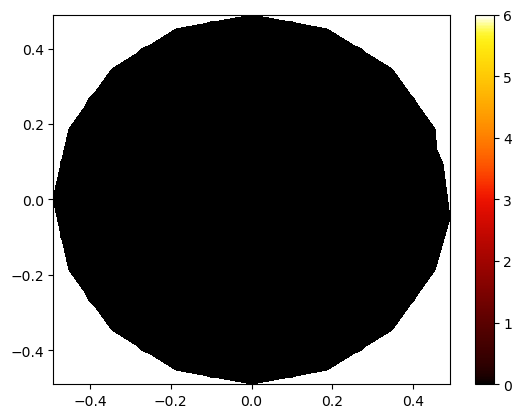

In [22]:
Mbh = 10**6
Rt =  Mbh**(1/3) #tidal radius
apocenter = 2 * Rt * Mbh**(1/3)
fig, ax = plt.subplots()
img = ax.pcolormesh(x/apocenter, y/apocenter, Den_casted.T, cmap='cet_fire', vmin = 0, vmax = 6) # vmin = 15, vmax = 25)
# ax.set_ylim(-0.1, 1.5)
# ax.set_xlim(-1, 1)
fig.colorbar(img)
plt.show()
